# Problem Statement

## How is RSGS affected by existing geosynchrouns satellites and debris?

### Motivation

1. Critical component for mission management and architecture.
2. Regulatory entities have strong concerns about collision. 
3. Inspired by Draper's work on RPO.
4. Personal interest in orbital mechanics and analysis.

### Track Geo satellites!

In [1]:
from IPython.display import HTML
HTML('<img src="./jupyter/geo8.gif">')

This is how to show geo satellies

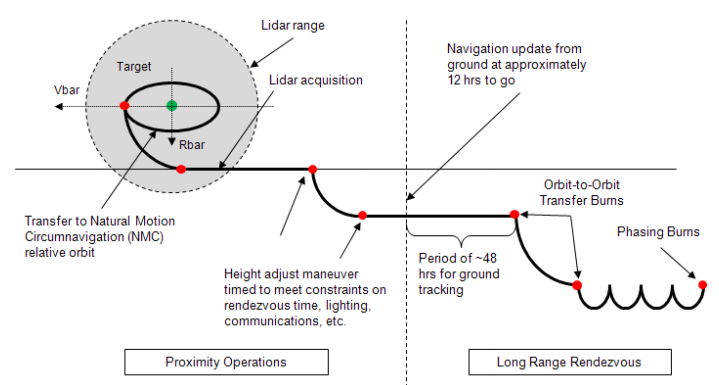

In [2]:
from IPython.display import Image
Image(filename='jupyter/rpo.png')

*credit: Ian T Mitchell, Draper Laboratory Overview of Rendezvous and Capture Operations, sspd.gsfc.nasa.gov, 2010, without permission*

In [3]:
import sys
import pickle
import numpy as nmp
import coord_trans

from tqdm import tqdm
from satellite import Satellite
from satellite import RSGS
#from graph import Graph
from graph import GraphFrame
from datetime import datetime, timedelta

Load local tle file

Set input arguments:

epoch start

epoch end (relative time after)

start longitude

target name


Epoch 0 is pulled from the TLE; gives the most accurate orbit

Epoch 1 is the start time of the simulation

Epoch 2 is the end time of the simulation

In [4]:
days = 0
hours = 3
epoch1 = datetime.utcnow()
epoch2 = epoch1 + timedelta(days,0,0,0,0,hours)
#datetime.timedelta([d,] [sec,] [microsec,] [msec,] [min,] [hr,] [week])

lon0 = 160
target_name = 'INTELSAT 19'

load TLE file locally (normally done live via spacetrack.org)

In [5]:
with open('tle/geo.tle', 'rb') as f:
    tle_list = pickle.load(f)

Calculate TLE orbits

lon0 is the global starting point; defined by user

lon1 is the tracked satellite's longitude

lon2 is the global ending point; target's longitude

In [6]:
sat_list = [Satellite(epoch1, epoch2) for n in range(0, len(tle_list), 3)]

for n, sat in enumerate(tqdm(sat_list, desc='Loading Satellites')):
    tle = tle_list[n*3:n*3+3]
    sat.load_tle(tle)

    if target_name in sat.name:
        sat.type = 'target'
        sat_target = sat

Loading Satellites: 100%|██████████| 1354/1354 [00:03<00:00, 378.26it/s]


Parse out only objects in specified region

In [7]:
lon2 = sat_target.lon[0]
lon0 = lon0 - nmp.sign(lon0)*2
lon2 = lon2 - nmp.sign(lon2)*2

tmp_list = []
for n, sat in enumerate(sat_list):
    lon1 = sat.lon[0]

    if (lon1 >= lon0 and lon1 <= lon2 and lon2 > lon0) \
    or (lon1 <= lon0 and lon1 >= lon2 and lon2 < lon0):
        tmp_list.append(sat)

sat_list = tmp_list

ADD RSGS

In [8]:
rsgs = RSGS(epoch1, epoch2)
rsgs.set_params(lon0, lon2)

Calculate motion for all epochs

In [9]:
for n, sat in enumerate(tqdm(sat_list, desc='Computing Motion')):
    sat.get_motion()
    sat.get_range(rsgs)

Computing Motion: 100%|██████████| 18/18 [00:00<00:00, 66.95it/s]


Calculate frames for 3D animation

In [10]:
sat_list.append(rsgs)
frame_cnt = sat_list[0].sim_cnt
frame_list = [GraphFrame(sat_list) for n in range(frame_cnt)]

for n, frame in enumerate(tqdm(frame_list, desc='Building Frames')):
    frame.load_data(n)

Building Frames: 100%|██████████| 10/10 [00:00<00:00, 5866.98it/s]


print results and graph

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

class Graph():

    def __init__(self, frame_list, lon0, lon2, epoch1):
        self.frame_list = frame_list
        self.lon0 = lon0
        self.lon2 = lon2
        self.epoch1 = epoch1
        self.fig, self.ax, self.txt = self._setup_fig()
        self.frame_cnt = len(self.frame_list)

    def _setup_fig(self):
        gs = grs.GridSpec(1, 2, width_ratios=[4,1])
        fig = plt.figure(figsize=(8,6))
        fig.set_size_inches(14, 10, True)
        ax = fig.add_subplot(gs[0], projection='3d')
        ax2 = fig.add_subplot(gs[1])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        plt.tight_layout(pad=0)
        return fig, ax, ax2

    def run(self):
        ani = animation.FuncAnimation(
                fig=self.fig,
                init_func=self._init_graph,
                func=self._update_graph,
                frames=self.frame_cnt,
                interval=600)
        return ani
        

    def _init_graph(self):
        self.ax.set_xlabel('Latitude, $\circ$E')
        self.ax.set_ylabel('Longitude, $\circ$E')
        self.ax.set_zlabel('Altitude, km')
        self.ax.set_xlim3d(-15,15)
        self.ax.set_zlim3d(35600,36100)
        if self.lon2 > self.lon0:
            self.ax.set_ylim3d(self.lon0-2, self.lon2+2)
        else:
            self.ax.set_ylim3d(self.lon0+2, self.lon2-2)
        self.txt.grid(False)
        self.txt.set_xticks([])
        self.txt.set_yticks([])

    def _update_graph(self, f):
        frame = self.frame_list[f]

        self.ax.clear()
        self.txt.clear()
        self._init_graph()

        self._update_sats(frame)
        self._update_text(frame)

    def _update_sats(self, frame):
        for n in range(len(frame.lon)):
            x, y, z, s, c, m, name = frame.get_params(n)

            center = (self.lon2+self.lon0)/2
            self.ax.scatter(x, y, z, s=s, c=c, marker=m)
            self.ax.text(x, y, z+10, '%s'%(name), size=5, zorder=1)

    def _update_text(self, frame):
        self.txt.text(0,0.92,'Epoch Start:', size=9)
        self.txt.text(0.1,0.90,'%s'%(self.epoch1), size=9)
        self.txt.text(0,0.82,'Mission Time:', size=9)
        self.txt.text(0.1,0.8,'%.2f hr'%(frame.mission_time), size=9)
        self.txt.text(0,0.72,'Range to Object, km:', size=9)

        for n, r in enumerate(frame.range[0:10]):
            name = frame.name_sorted[n]
            color = frame.range_color[n]
            self.txt.text(0.1, 0.7-n*0.015,'%.2f'%(r), size=9, color=color)
            self.txt.text(0.35, 0.7-n*0.015,'%s'%(name), size=9, color=color)

In [12]:
#grf = Graph(frame_list, lon0, lon2, epoch1)
#ani = grf.run()
#from IPython.display import HTML
#HTML(ani.to_html5_video())